In [1]:
# Load required libraries
import torch
from torch import optim
import copy
import numpy as np
# -custom-written libraries
import utils
from data.load import get_context_set
from models.classifier import Classifier
from train.train_task_based import train_cl
from eval import evaluate, callbacks as cb
from visual import visual_plt

In [2]:
# Enable plotting in the notebook
%matplotlib inline  

In [3]:
# Is cuda available?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA is {}used".format("" if cuda else "not "))

CUDA is used


## DATA: Prepare the data

In [4]:
# Specify what kind of continual learning experiment we should run
experiment = "splitMNIST"  #--> create context set by splitting up the MNIST dataset
contexts = 5               #--> split the dataset up into how many contexts?
iters = 500                #--> number of iterations per context
batch = 128                #--> number of samples per iteration (i.e., the mini-batch size)

In [5]:
# Specify according to which scenario the continual learning experiment should be performed?
scenario = "class"

In [6]:
# Where is, or should, the data be stored?
d_dir = './store/datasets'

In [8]:
# Load the context set (both train- and test-data) for the specified continual learning experiment
(train_datasets, test_datasets), config = get_context_set(
    name=experiment, scenario=scenario, contexts=contexts, data_dir=d_dir, verbose=True, exception=True,
)

 --> MNIST: 'train'-dataset consisting of 60000 samples
 --> MNIST: 'test'-dataset consisting of 10000 samples


## CLASSIFIER: Specify the classifier network

In [9]:
# Specify the architectural layout of the network to use
fc_lay = 3        #--> number of fully-connected layers
fc_units = 400    #--> number of units in each hidden layer
fc_bn = False     #--> use batch-norm
fc_nl = "relu"    #--> what non-linearity to use?

In [10]:
# Define the model
model = Classifier(
    image_size=config['size'], image_channels=config['channels'], classes=config['output_units'],
    # -conv-layers are not used
    depth=0,
    # -fc-layers
    fc_layers=fc_lay, fc_units=fc_units, fc_bn=fc_bn, fc_nl=fc_nl, excit_buffer=True,
).to(device)

In [11]:
# Indicate to model what scenario it will be trained on and how many classes there are in each context
model.scenario = scenario
model.classes_per_context = config['classes_per_context']

In [12]:
# Print layout of the model to the screen
utils.print_model_info(model)

-------------------------------------------------------
Classifier(
  (convE): ConvLayers(
    (pooling): Identity()
  )
  (flatten): Flatten()
  (fcE): MLP(
    (fcLayer1): fc_layer(
      (linear): LinearExcitability(in_features=784, out_features=400)
      (nl): ReLU()
    )
    (fcLayer2): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=400)
      (nl): ReLU()
    )
  )
  (classifier): fc_layer(
    (linear): LinearExcitability(in_features=400, out_features=10)
  )
)
-------------------------------------------------------
--> this network has 478410 parameters (~0.5 million)
       of which: - learnable: 478410 (~0.5 million)
                 - fixed: 0 (~0.0 million)


#### Create several copies of the network, which each will be trained with a different continual learning method 

In [13]:
# -baseline
model_naive = copy.deepcopy(model)
# -different continual learning methods (each method illustrates a different strategy)
model_si = copy.deepcopy(model)
model_lwf = copy.deepcopy(model)
model_er = copy.deepcopy(model)
if scenario=="task":
    model_xdg = copy.deepcopy(model)
if scenario=="class":
    model_icarl = copy.deepcopy(model)

## CL-STRATEGY: Specify the continual learning strategy to use

### Parameter Regularization

In [14]:
# Synaptic Intelligence (SI)
model_si.weight_penalty = True
model_si.importance_weighting = 'si'
model_si.reg_strength = 100.

### Functional Regularization

In [15]:
# Learning without Forgetting (LwF)
model_lwf.replay_mode = 'current'
model_lwf.replay_targets = 'soft'
model_lwf.KD_temp = 2.
model_lwf.lwf_weighting = True

### Replay

In [16]:
# Experience Replay (ER)
model_er.replay_mode = 'buffer'
model_er.use_memory_buffer = True
model_er.budget_per_class = 100
model_er.sample_selection = 'random'

### Context-specific components

In [17]:
# Context-specific Gating (XdG)
gating_prop = 0.9
if scenario=="task":
    model_xdg.mask_dict = {}
    model_xdg.excit_buffer_list = []
    for context_id in range(contexts):
        model_xdg.mask_dict[context_id + 1] = {}
        for i in range(model_xdg.fcE.layers):
            # For each fully-connected hidden layer, define for every context a random mask of units to set to zero
            layer = getattr(model_xdg.fcE, "fcLayer{}".format(i + 1)).linear
            if context_id == 0:
                model_xdg.excit_buffer_list.append(layer.excit_buffer)
            n_units = len(layer.excit_buffer)
            gated_units = np.random.choice(n_units, size=int(gating_prop * n_units), replace=False)
            model_xdg.mask_dict[context_id + 1][i] = gated_units

### Template-based Classification

In [18]:
# Incremental Classification and Represenation Learning (iCaRL)
if scenario=="class":
    model_icarl.use_memory_buffer = True
    model_icarl.budget_per_class = 100
    model_icarl.sample_selection = 'herding'
    model_icarl.norm_exemplars = True
    model_icarl.add_buffer = True
    model_icarl.prototypes = True
    model_icarl.binaryCE = True
    model_icarl.binaryCE_distill = True

## CALLBACKS: Specify callback-functions to get insight into training progress

In [19]:
# Callback-function that provides a tqdm progress bar for during training, reporting training loss and accuracy
loss_cbs = [cb._classifier_loss_cb(contexts=contexts, iters_per_context=iters)]

In [20]:
# Prepare for keeping track of performance (on test set) during training, for later plotting
plotting_dict_naive = evaluate.initiate_plotting_dict(contexts)
plotting_dict_si = evaluate.initiate_plotting_dict(contexts)
plotting_dict_lwf = evaluate.initiate_plotting_dict(contexts)
plotting_dict_er = evaluate.initiate_plotting_dict(contexts)
if scenario=="task":
    plotting_dict_xdg = evaluate.initiate_plotting_dict(contexts)
if scenario=="class":
    plotting_dict_icarl = evaluate.initiate_plotting_dict(contexts)

In [21]:
# Callback-function to track test accuracy during training, for later plotting
context_cbs_naive = [
    cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_naive, iters_per_context=iters)
]
context_cbs_si = [
    cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_si, iters_per_context=iters)
]
context_cbs_lwf = [
    cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_lwf, iters_per_context=iters)
]
context_cbs_er = [
    cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_er, iters_per_context=iters)
]
if scenario=="task":
    context_cbs_xdg = [
        cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_xdg, iters_per_context=iters)
    ]
if scenario=="class":
    context_cbs_icarl = [
        cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_icarl, iters_per_context=iters)
    ]

## TRAIN: Train the model on the continual learning experiment

In [22]:
# Settings for the optimizer to use
lr = 0.001           #--> learning rate to use

In [23]:
# For each model, set up the optimizer to use
model_list = [model_naive, model_si, model_lwf, model_er]
if scenario=="task":
    model_list.append(model_xdg)
if scenario=="class":
    model_list.append(model_icarl)
for model in model_list:
    model.optim_list = [{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': lr}]
    model.optimizer = optim.Adam(model.optim_list, betas=(0.9, 0.999))

#### Train all the models using different continual learning methods

In [24]:
# Naive baseline
train_cl(
    model_naive, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_naive,
)

<CLASSIFIER> | Context: 1/5 | training loss: 1.05e-05 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:10<00:00, 47.20it/s]
<CLASSIFIER> | Context: 2/5 | training loss: 0.0128 | training accuracy: 0.992 |: 100%|██████████████████████████████| 500/500 [00:10<00:00, 49.12it/s]
<CLASSIFIER> | Context: 3/5 | training loss: 0.000898 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:10<00:00, 48.89it/s]
<CLASSIFIER> | Context: 4/5 | training loss: 0.000352 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:10<00:00, 49.36it/s]
<CLASSIFIER> | Context: 5/5 | training loss: 0.00319 | training accuracy: 1.0 |: 100%|███████████████████████████████| 500/500 [00:09<00:00, 50.34it/s]


In [25]:
# Synaptic Intelligence
train_cl(
    model_si, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_si,
)

<CLASSIFIER> | Context: 1/5 | training loss: 6.23e-05 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:10<00:00, 47.72it/s]
<CLASSIFIER> | Context: 2/5 | training loss: 0.0373 | training accuracy: 1.0 |: 100%|████████████████████████████████| 500/500 [00:11<00:00, 43.94it/s]
<CLASSIFIER> | Context: 3/5 | training loss: 0.0161 | training accuracy: 1.0 |: 100%|████████████████████████████████| 500/500 [00:11<00:00, 44.69it/s]
<CLASSIFIER> | Context: 4/5 | training loss: 0.00592 | training accuracy: 1.0 |: 100%|███████████████████████████████| 500/500 [00:11<00:00, 44.42it/s]
<CLASSIFIER> | Context: 5/5 | training loss: 0.0707 | training accuracy: 0.984 |: 100%|██████████████████████████████| 500/500 [00:10<00:00, 47.00it/s]


In [26]:
# Learning without Forgetting
train_cl(
    model_lwf, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_lwf,
)

<CLASSIFIER> | Context: 1/5 | training loss: 3.24e-06 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:08<00:00, 56.95it/s]
<CLASSIFIER> | Context: 2/5 | training loss: 1.46 | training accuracy: 0.992 |: 100%|████████████████████████████████| 500/500 [00:09<00:00, 50.88it/s]
<CLASSIFIER> | Context: 3/5 | training loss: 1.97 | training accuracy: 1.0 |: 100%|██████████████████████████████████| 500/500 [00:09<00:00, 52.16it/s]
<CLASSIFIER> | Context: 4/5 | training loss: 2.3 | training accuracy: 1.0 |: 100%|███████████████████████████████████| 500/500 [00:09<00:00, 52.21it/s]
<CLASSIFIER> | Context: 5/5 | training loss: 2.49 | training accuracy: 1.0 |: 100%|██████████████████████████████████| 500/500 [00:09<00:00, 51.95it/s]


In [27]:
# Experience Replay
train_cl(
    model_er, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_er,
)

<CLASSIFIER> | Context: 1/5 | training loss: 9.88e-06 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:09<00:00, 50.40it/s]
<CLASSIFIER> | Context: 2/5 | training loss: 0.00253 | training accuracy: 1.0 |: 100%|███████████████████████████████| 500/500 [00:11<00:00, 44.84it/s]
<CLASSIFIER> | Context: 3/5 | training loss: 0.00109 | training accuracy: 1.0 |: 100%|███████████████████████████████| 500/500 [00:10<00:00, 47.07it/s]
<CLASSIFIER> | Context: 4/5 | training loss: 0.000389 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:09<00:00, 50.39it/s]
<CLASSIFIER> | Context: 5/5 | training loss: 0.00527 | training accuracy: 0.984 |: 100%|█████████████████████████████| 500/500 [00:09<00:00, 50.81it/s]


In [28]:
# XdG
if scenario=="task":
    train_cl(
        model_xdg, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_xdg,
    )

In [29]:
# iCaRL
if scenario=="class":
    train_cl(
        model_icarl, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_icarl,
    )

<CLASSIFIER> | Context: 1/5 | training loss: 0.000369 | training accuracy: 1.0 |: 100%|██████████████████████████████| 500/500 [00:08<00:00, 55.57it/s]
<CLASSIFIER> | Context: 2/5 | training loss: 0.397 | training accuracy: 0.859 |: 100%|███████████████████████████████| 500/500 [00:09<00:00, 50.54it/s]
<CLASSIFIER> | Context: 3/5 | training loss: 1.37 | training accuracy: 0.977 |: 100%|████████████████████████████████| 500/500 [00:09<00:00, 51.36it/s]
<CLASSIFIER> | Context: 4/5 | training loss: 2.95 | training accuracy: 0.953 |: 100%|████████████████████████████████| 500/500 [00:08<00:00, 55.88it/s]
<CLASSIFIER> | Context: 5/5 | training loss: 4.05 | training accuracy: 0.945 |: 100%|████████████████████████████████| 500/500 [00:10<00:00, 49.02it/s]


## EVALUATION: Plot average accuracy curves throughout training for compared methods

In [30]:
# Collect data for the lines to plot
lines_to_plot = [
    plotting_dict_naive["average"],
    plotting_dict_si["average"],
    plotting_dict_lwf["average"],
    plotting_dict_er["average"]
]
if scenario=="task":
    lines_to_plot.append(plotting_dict_xdg["average"])
if scenario=="class":
    lines_to_plot.append(plotting_dict_icarl["average"])

In [31]:
# Specify labels and layout for the plot
line_names = ['Naive', 'SI', 'LwF', 'ER']
line_colors = ['grey', 'yellowgreen', 'gold', 'red']
if scenario=="task":
    line_names.append('XdG')
    line_colors.append('deepskyblue')
if scenario=="class":
    line_names.append('iCaRL')
    line_colors.append('purple')

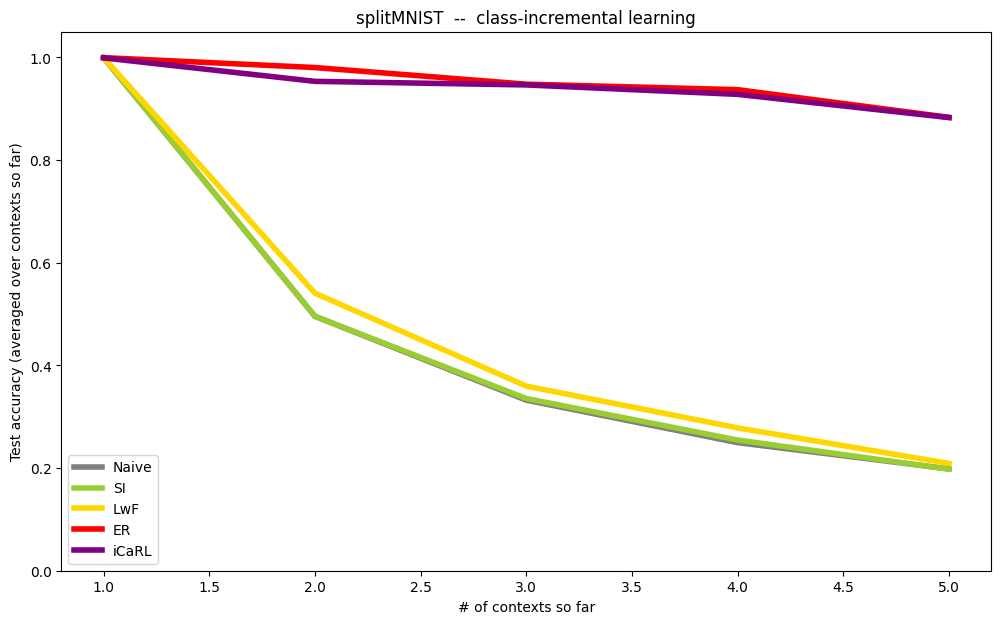

In [32]:
# Create the plot
figure = visual_plt.plot_lines(
    lines_to_plot, x_axes=plotting_dict_naive["x_context"], line_names=line_names, colors=line_colors,
    ylabel="Test accuracy (averaged over contexts so far)", ylim=(0,1.05) if scenario=="class" else None,
    xlabel="# of contexts so far", title="{}  --  {}-incremental learning".format(experiment, scenario)
)